Generate training data using cellular flow

In [1]:
# add parent folder to search directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from MR import MaxeyRiley
from flows.cellular import cellular_flow
from scipy.stats import gaussian_kde

In [53]:
np.random.seed(666)

R = 1.55
ep = 0.05
dt = 2e-3

samples = 1000
traj_len = 15e2
X, V, U, DUDt = [], [], [], []
Vm = []    # first order estimate of manifold velocity
L = []    # stability criterion

for n in np.arange(samples):
    
    A = np.random.rand()*5 + 15
    B = np.random.rand()*3
    w = np.random.rand()*np.pi*4
    cf = cellular_flow(A=A, B=B, w=w)
    mr = MaxeyRiley(ep, R, cf)
    
    x0 = np.random.rand(2,)*2*np.pi
    v0 = mr.order1_manifold_vel(x0)
    t = 0
    x, v, u, DuDt = [], [], [], []
    vm = []
    l = []
    
    for i in np.arange(traj_len):
        
        x1, v1 = mr.RK4step(x0, v0, dt, t)
        u1 = cf.vel(x1, t+dt)
        DuDt1 = cf.DuDt(x1, t+dt)
        vm1 = u1 + ep*(3/2*R - 1)*DuDt1
        
        # record
        x.append(x1)
        v.append(v1)
        u.append(u1)
        DuDt.append(DuDt1)
        vm.append(vm1)
        l.append(cf.lmin(x1, 1/ep, t))
        
        # update
        x0, v0 = x1, v1
        t += dt
        
    X.append(np.array(x))
    V.append(np.array(v))
    Vm.append(np.array(vm))
    U.append(np.array(u))
    DUDt.append(np.array(DuDt))
    L.append(l)
        
X, V, U, DUDt = np.array(X), np.array(V), np.array(U), np.array(DUDt)
Vm = np.array(Vm)
L = np.array(L)

print(X.shape)
print(DUDt.shape)

(1000, 1500, 2)
(1000, 1500, 2)


# Verify single trajectory by through plot

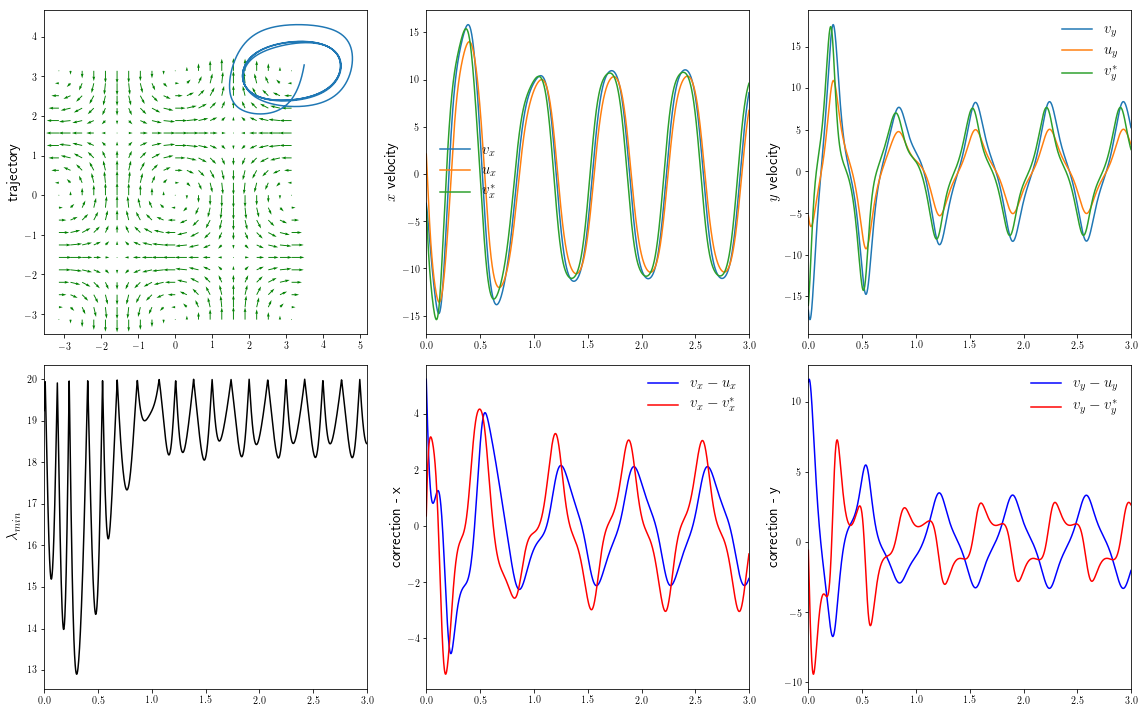

In [60]:
N = 20
ls = np.linspace(-np.pi, np.pi, N+1)
xx, yy = np.meshgrid(ls, ls, indexing='ij')
XX = np.stack((xx, yy), axis=-1)
Uf = cf.vel(XX)

# X1 = np.mod(X, 2*np.pi)
# X1 = X1 - (X1>np.pi)*2*np.pi

plt.rc('text', usetex=True)

case = 117
fig, ax = plt.subplots(2, 3, figsize=(16,10))
ax[0,0].quiver(xx, yy, Uf[...,0], Uf[...,-1], color='g')
ax[0,0].plot(X[case, :, 0], X[case, :, 1])
ax[0,0].set_ylabel('trajectory', size=15)

ax[0,1].plot(np.arange(traj_len)*dt, V[case, :, 0], label='$v_x$')
ax[0,1].plot(np.arange(traj_len)*dt, U[case, :, 0], label='$u_x$')
ax[0,1].plot(np.arange(traj_len)*dt, Vm[case, :, 0], label='$v^{*}_x$')
ax[0,1].set_xlim([0, traj_len*dt])
# ax[0,1].set_ylim([-30, 30])
ax[0,1].legend(frameon=False, fontsize=15)
ax[0,1].set_ylabel('$x$ velocity', size=15)

ax[0,2].plot(np.arange(traj_len)*dt, V[case, :, 1], label='$v_y$')
ax[0,2].plot(np.arange(traj_len)*dt, U[case, :, 1], label='$u_y$')
ax[0,2].plot(np.arange(traj_len)*dt, Vm[case, :, 1], label='$v^{*}_y$')
ax[0,2].set_xlim([0, traj_len*dt])
# ax[0,2].set_ylim([-30, 30])
ax[0,2].legend(frameon=False, fontsize=15)
ax[0,2].set_ylabel('$y$ velocity', size=15)

ax[1,0].plot(np.arange(traj_len)*dt, L[case, :], 'k-')
ax[1,0].set_xlim([0, traj_len*dt])
ax[1,0].set_ylabel('$\lambda_{min}$', size=15)

ax[1,1].plot(np.arange(traj_len)*dt, U[case, :, 0] - V[case, :, 0], 'b-', label='$v_x-u_x$')
ax[1,1].plot(np.arange(traj_len)*dt, V[case, :, 0] - Vm[case, :, 0], 'r-', label='$v_x-v^*_x$')
ax[1,1].set_xlim([0, traj_len*dt])
ax[1,1].legend(frameon=False, fontsize=15)
ax[1,1].set_ylabel('correction - x', size=15)

ax[1,2].plot(np.arange(traj_len)*dt, U[case, :, 1] - V[case, :, 1], 'b-', label='$v_y-u_y$')
ax[1,2].plot(np.arange(traj_len)*dt, V[case, :, 1] - Vm[case, :, 1], 'r-', label='$v_y-v^*_y$')
ax[1,2].set_xlim([0, traj_len*dt])
ax[1,2].legend(frameon=False, fontsize=15)
ax[1,2].set_ylabel('correction - y', size=15)

plt.tight_layout()
plt.show()

# Plot PDFs

In [12]:
def pdf(data, pts=500):
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), pts)
    p = kde(x)
    return x,p

In [62]:
s1 = 5    # steps for time: i.e. s1=2 -> take every other time step
s2 = 1    # steps for particles

Plot stability density: make sure no density for $L < 0$

In [72]:
Lx, pLx = pdf(L.flatten())

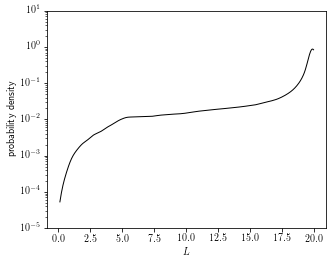

In [75]:
fig6, ax6 = plt.subplots(figsize=(5,4))
ax6.semilogy(Lx, pLx, 'k-', linewidth=1)
ax6.set_ylim([1e-5, 1e1])
ax6.set_xlabel('$L$')
ax6.set_ylabel('probability density')

plt.show()

Plot encountered flow velocity U

In [63]:
ux, pux = pdf(U[::s2, ::s1, 0].flatten())
uy, puy = pdf(U[::s2, ::s1, 1].flatten())

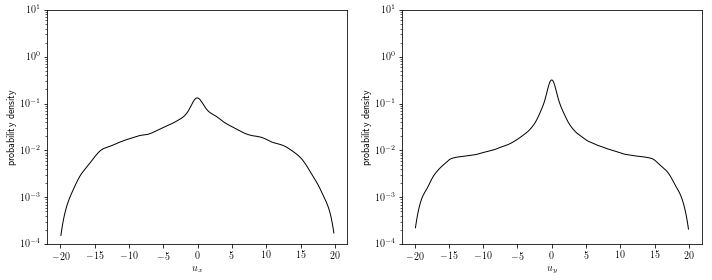

In [64]:
fig2, ax2 = plt.subplots(1, 2, figsize=(10,4))
ax2[0].semilogy(ux, pux, 'k-', linewidth=1)
ax2[0].set_ylim([1e-4, 1e1])
ax2[0].set_xlabel('$u_x$')
ax2[0].set_ylabel('probability density')

ax2[1].semilogy(uy, puy, 'k-', linewidth=1)
ax2[1].set_ylim([1e-4, 1e1])
ax2[1].set_xlabel('$u_y$')
ax2[1].set_ylabel('probability density')

plt.tight_layout()
plt.show()

Plot encountered DU/Dt

In [65]:
Dux, pDux = pdf(DUDt[::s2, ::s1, 0].flatten())
Duy, pDuy = pdf(DUDt[::s2, ::s1, 1].flatten())

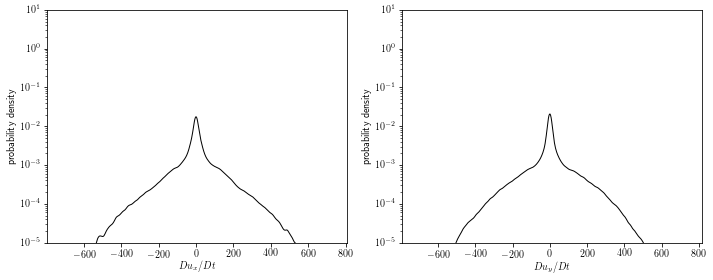

In [66]:
fig3, ax3 = plt.subplots(1, 2, figsize=(10,4))
ax3[0].semilogy(Dux, pDux, 'k-', linewidth=1)
ax3[0].set_ylim([1e-5, 1e1])
ax3[0].set_xlabel('$Du_x/Dt$')
ax3[0].set_ylabel('probability density')

ax3[1].semilogy(Duy, pDuy, 'k-', linewidth=1)
ax3[1].set_ylim([1e-5, 1e1])
ax3[1].set_xlabel('$Du_y/Dt$')
ax3[1].set_ylabel('probability density')

plt.tight_layout()
plt.show()

Plot target V - Vm

In [67]:
V_Vm = V - Vm
v_vmx, pv_vmx = pdf(V_Vm[::s2, ::s1, 0].flatten())
v_vmy, pv_vmy = pdf(V_Vm[::s2, ::s1, 1].flatten())

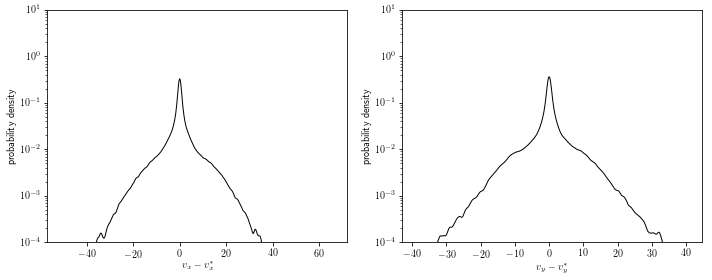

In [68]:
fig4, ax4 = plt.subplots(1, 2, figsize=(10,4))
ax4[0].semilogy(v_vmx, pv_vmx, 'k-', linewidth=1)
ax4[0].set_ylim([1e-4, 1e1])
ax4[0].set_xlabel('$v_x - v^*_x$')
ax4[0].set_ylabel('probability density')

ax4[1].semilogy(v_vmy, pv_vmy, 'k-', linewidth=1)
ax4[1].set_ylim([1e-4, 1e1])
ax4[1].set_xlabel('$v_y - v^*_y$')
ax4[1].set_ylabel('probability density')

# plt.savefig('pdf_DUxDt.png', dpi=200);
plt.tight_layout()
plt.show()

Plot V - U, difference between particle and flow velocities

In [69]:
V_U = V - U
v_ux, pv_ux = pdf(V_U[::s1, ::s2, 0].flatten())
v_uy, pv_uy = pdf(V_U[::s1, ::s2, 1].flatten())

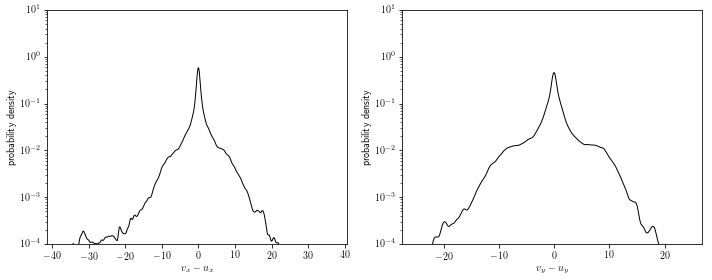

In [70]:
fig5, ax5 = plt.subplots(1, 2, figsize=(10,4))
ax5[0].semilogy(v_ux, pv_ux, 'k-', linewidth=1)
ax5[0].set_ylim([1e-4, 1e1])
ax5[0].set_xlabel('$v_x - u_x$')
ax5[0].set_ylabel('probability density')

ax5[1].semilogy(v_uy, pv_uy, 'k-', linewidth=1)
ax5[1].set_ylim([1e-4, 1e1])
ax5[1].set_xlabel('$v_y - u_y$')
ax5[1].set_ylabel('probability density')

plt.tight_layout()
plt.show()

# Save data file

In [71]:
np.savez("cf_training.npz", X=X, V=V, U=U, DUDt=DUDt, Vm=Vm, L=L)